PDHG algorithm

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
from modopt.math.metrics import ssim

import numpy as np
import matplotlib.pyplot as plt

## Import data and add noise

### Fourier operator and noise

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

# Adding noise
(n1,n2) = u0.shape
s = 2e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(np.real(u0.data))+s*np.random.randn(2*n*n).view(np.complex128)
u0_mat = np.asarray(u0)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Operators

In [4]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data

p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

new_loc = kspace_loc[np.where(p)]
#pysap.Image(data = convert_locations_to_mask(np.array(new_loc),u0.shape)).show()

#Wavelet
linear_op = WaveletN(wavelet_name="db8",nb_scale=4,padding_mode = "periodization")

In [5]:
#ifft on noised data = base result
uk = fourier_op.adj_op(p*y)
print(ssim(uk,u0_mat))
pysap.Image(data = np.abs(uk)).show()

0.5075374591157028


## Reconstruction

In [6]:
# Specific files import
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg

In [7]:
# -- Solving --
lower_level_parameters = {"zeta":1e15,"pn1":2e-6,"epsilon":1e-2,"gamma":1e-10}
# myconst = {"sigma":1.15,"tau":0.43}
uk,norms,energy = pdhg(y,p,fourier_op,linear_op,lower_level_parameters)

/home/guillaume/pysap-mri/Lower Level/algo/prox.py:8: RuntimeWarning: invalid value encountered in sqrt
  gamma*x/(c+0.5*gamma+np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))
/home/guillaume/pysap-mri/Lower Level/algo/prox.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.where(x>=0,x/(1+epsilon*c),x/(0.5+np.sqrt(0.25-3*zeta*c*x/(1+epsilon*c)**2)))


10  iterations:
Cost: 2.846621185054287e-07 
Norm: 0.14036964206037922 

20  iterations:
Cost: 2.567392991535402e-07 
Norm: 0.0659173130295577 

30  iterations:
Cost: 2.483477969209249e-07 
Norm: 0.03585498216377192 

40  iterations:
Cost: 2.449931131745948e-07 
Norm: 0.021584977910229182 

50  iterations:
Cost: 2.4337740913981843e-07 
Norm: 0.014525306148660122 

60  iterations:
Cost: 2.424980977746876e-07 
Norm: 0.010239578655844591 

70  iterations:
Cost: 2.4197555038311274e-07 
Norm: 0.007864072744165231 

80  iterations:
Cost: 2.4164431944395706e-07 
Norm: 0.006105595129180868 

90  iterations:
Cost: 2.41422095856355e-07 
Norm: 0.004851803343886008 

100  iterations:
Cost: 2.4126855081277726e-07 
Norm: 0.004015016996066158 

110  iterations:
Cost: 2.411598298664089e-07 
Norm: 0.00334339787539948 

120  iterations:
Cost: 2.410804788689084e-07 
Norm: 0.002871057261227533 

130  iterations:
Cost: 2.4101895786186995e-07 
Norm: 0.0024217258229842302 

140  iterations:
Cost: 2.409732237

In [8]:
#Showing
print(ssim(u0_mat,uk))
pysap.Image(data = np.real(uk)).show()

0.8638842273965522


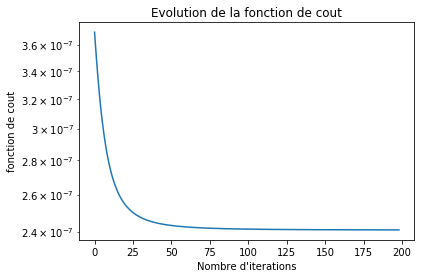

In [9]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Nombre d'iterations")
plt.ylabel("fonction de cout")
plt.title("Evolution de la fonction de cout")
plt.yscale("log")

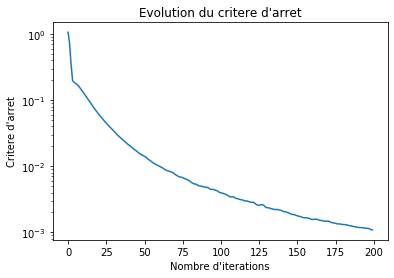

In [10]:
plt.plot(norms)
plt.yscale("log")
plt.xlabel("Nombre d'iterations")
plt.ylabel("Critere d'arret")
plt.title("Evolution du critere d'arret")
plt.yscale("log")